In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/chest_xray"))

# Any results you write to the current directory are saved as output.

['chest_xray', '__MACOSX']


In [2]:
print(os.listdir("../input/chest_xray/chest_xray/train"))


['NORMAL', 'PNEUMONIA', '.DS_Store']


# Import Libraries

In [3]:
# Import libraries
import numpy as np
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


# Define Parameters

In [13]:
## define parameters
print("\nDefining metadata")
Nrows = 150
Ncols = 150
BATCH_SIZE = 128
NUM_EPOCHS = 15
FILTER_SIZE = (3,3)
model_path = "../model"+"_R"+str(Nrows)+"_C"+str(Ncols)+"_fs"+str(FILTER_SIZE[0])+"_ep"+str(NUM_EPOCHS)+".h5"
print("\nMetadata defined")


Defining metadata

Metadata defined


# Define function to plot results

In [5]:
def plot_results(history):
    # Retrieve a list of list results on training and val data
    # sets for each training epoch
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    # Get number of epochs
    epochs=range(len(acc)) 
    
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.figure()
    
    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    
    plt.title('Training and validation loss')

# Define Callback

In [6]:
# define callbacks

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if (logs.get('acc') > 0.99):
            self.model.stop_training = True
            print ("\nStopping training as accuracy is above 99%")
callback = myCallback()

# Load data using ImageDataGenerator

In [7]:
## load data - change directories to the location of data

print("\nLoading data...")
train_dir = "../input/chest_xray/chest_xray/train"
val_dir = "../input/chest_xray/chest_xray/val"
test_dir = "../input/chest_xray/chest_xray/test"

train_data_gen = ImageDataGenerator(rescale=1/255.0,
                                      rotation_range=40,
                                      shear_range=0.2,
                                      horizontal_flip=True,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      zoom_range=0.3)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_gen = train_data_gen.flow_from_directory( train_dir,
                                                target_size=((Nrows, Ncols)),
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary')
val_gen = val_data_gen.flow_from_directory(val_dir,
                                            target_size=((Nrows, Ncols)),
                                            class_mode='binary')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                            target_size=((Nrows, Ncols)),
                                            class_mode='binary')
print("\nData Generators defined")


Loading data...
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Data Generators defined


# Define Model

In [9]:
# define model

print("\nDefining model...")
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(Nrows, Ncols, 3))
last_layer = base_model.get_layer('mixed4')
last_output = last_layer.output

# Make base_model non-trainable
for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.Conv2D(256, FILTER_SIZE, activation='relu')(last_output)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)



Defining model...


# Compile Model

In [10]:
## compile model
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 74, 74, 32)   96          conv2d_96[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_v1_94[0][0]  
__________________________________________________________________________________________________
conv2d_97 

# Train Model

In [11]:
## fit model to data - training
history = model.fit_generator(train_gen,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=100,
                              validation_steps=50,
                              validation_data=val_gen,
                              verbose=1,
                              callbacks=[callback])
print("\nNew model trained")

Epoch 1/2
1/1 [==============================] - 1s 1s/step - loss: 7.9712 - acc: 0.5000
 - 80s - loss: 4.0550 - acc: 0.7339 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 241ms/step - loss: 7.9712 - acc: 0.5000
 - 73s - loss: 4.1010 - acc: 0.7429 - val_loss: 7.9712 - val_acc: 0.5000

New model trained


# Save model and plot results


Saving model for later use...

Model Successfully saved

Plotting results...

........................


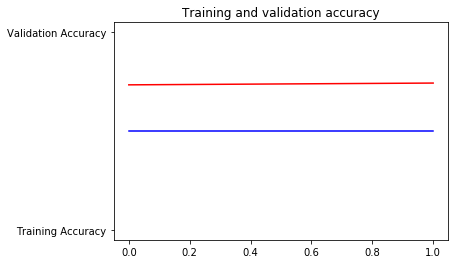

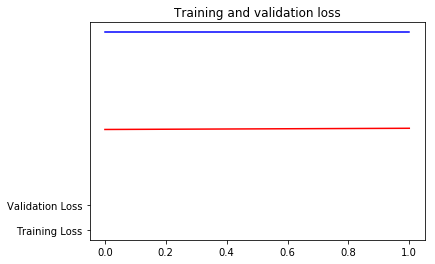

In [14]:
## save model to file
print("\nSaving model for later use...")
model.save(model_path)
print("\nModel Successfully saved")


In [ ]:
## plot results
print("\nPlotting results...")
plot_results(history)
print("\n........................")

# Evaluate model on test data

In [15]:
# evaluate model
loss, acc = model.evaluate_generator(test_gen, verbose=1)
print ("\nTest acc : " + str(acc))
print ("\nTest loss: " + str(loss))


20/20 [==============================] - 7s 334ms/step - loss: 5.9784 - acc: 0.6250

Test acc : 0.625

Test loss: 5.9783945918083194
